# EDA - Exploratory Data Analysis
This notebook just for Descriptive Analysis to make inference about the dataset ES_0 (collected info from cimate station A612). 
With those inferences we will proceed to make our first models.

<a href="https://ibb.co/ZccxLYV"><img src="https://i.ibb.co/KVVW0LX/A612-Station.png" alt="A612-Station" border="0"></a>  
lat -20.2666, long -40.3

#### Objectives from this notebook:
1. understand the data
    1. define Y - Target variables (min max temperature and rain)
    1. descriptive
    2. understand basic sazonalities
    1. understand relations between variables
    2. check for outliers
2. Understand autoregressive structures
    1. Make linear models using non stocastic variables
    2. ACF and PACF from linear regression errors
    3. Check for sazonalities in errors

### Proposal notebook structure:
1. Imports and adding non-stocastic covariables
<!-- 2. Descriptive about the dataframe -->
2. Y - Targets variables descriptive
    1. year, month and day Boxplots
    2. Lineplot with min and max temperatures
    3. histogram plot with rain
3. X
    1. Histogram
    2. Lineplots
    4. Crosstable just with target variables
4. Errors from Linear Regression
    1. First model: OLS with non-stocastic variables (month dummies and transformed hour)
    2. Analyse the errors from the linear model
    3. Acf and pacf from errors
    4. Erros sazonality

## 1. Importing and adding basic covariables

In [2]:
from jh_utils.data.sql.connection import create_string_connection
from jh_utils.data.pandas.sql import get_sql_table

from sqlalchemy import create_engine
import numpy as np, pandas as pd, os

from dotenv import dotenv_values
env = dotenv_values('../../.env')

figsize = (20,7)
figsize2 = (20,5)

In [3]:
# getting the data
con = create_string_connection(database=env['db'], 
                  user=env['user'],
                  password=env['pass'], 
                  host=env['host1'],
                  port=env['port'])
con = create_engine(con)
query = 'select * from datasets."ES_0"'
df = get_sql_table(query, con)

### Reading data
Dataset 0 has 46 columns, for the Exploratory Data Analysis we just need the Index and the Maximum Temperature from Station A612.  
All other columns are dummies just needed to make the autoregressive models. To get the month and year information we will use methods from Pandas

In [4]:
## adding covariables
df['hour'] = df.date_time.dt.hour
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year
df['day_of_year'] = df.date_time.dt.day_of_year
df['weekofyear'] = df.date_time.dt.weekofyear

## transforming start hour in 9, to use hour**3, some models are hierarchical so is necessary to keep hour**2 
df['hour_9'] = df['hour'].apply(lambda x: (x-9)%24)
df['hour_9**2'] = df['hour_9']**2
df['hour_9**3'] = df['hour_9']**3

/home/joaoholz/miniconda3/envs/weather/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [5]:
## setting target variables to be easy to call later
y1 = 'A612 - precipitacao total, horario (mm)'
y2 = 'A612 - temperatura maxima na hora ant. (aut) (°c)'
y3 = 'A612 - temperatura minima na hora ant. (aut) (°c)'

---
## 2. Y - Target variables descriptive analysis

In [6]:
def two_line_plot(df, x1, x2, freq = 'M', figsize = (20,5), tittle = ''):
    temp = df[['date_time',x1,x2]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x1]).set_title(tittle,fontsize=20)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x2])
    
def two_hist_plot(df, x1, x2, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1,x2]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.histplot(df[x1],color = 'red').set_title(tittle,fontsize=20)
    _ = sns.histplot(df[x2]) 

def one_line_plot(df, x1, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x1]).set_title(tittle,fontsize=20)

def one_hist_plot(df, x1, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.histplot(df[x1],color = 'red').set_title(tittle,fontsize=20)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

## Min Max temperature

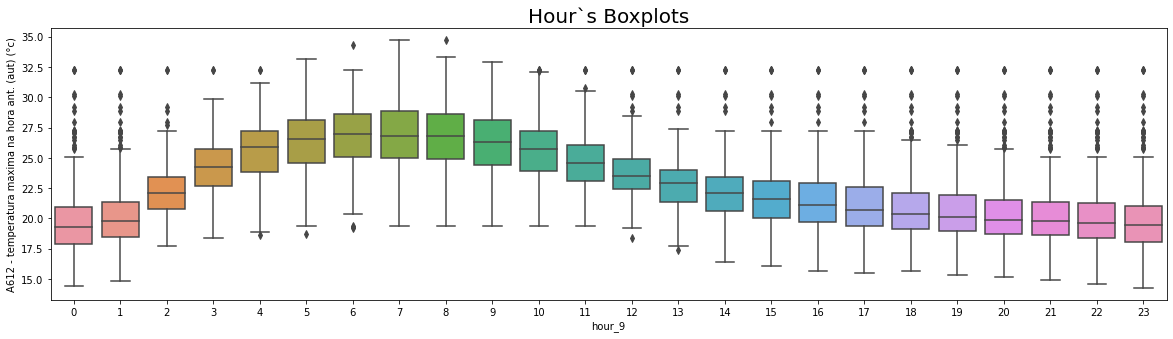

In [8]:
plt.figure(figsize=figsize2)
tittle = 'Hour`s Boxplots'
_ = sns.boxplot(data=df[df.month == 6],y = y2, x='hour_9').set_title(tittle,fontsize=20)
# _ = sns.lineplot(y = d1,x=list(range(0,23)))

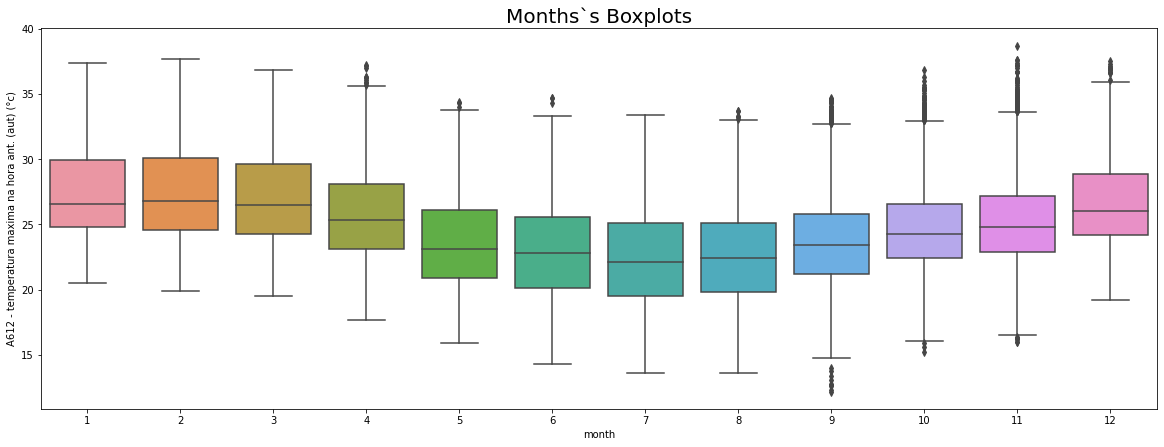

In [9]:
# change y for y1 and y2 to se other results
plt.figure(figsize=figsize)
tittle = 'Months`s Boxplots'
_ = sns.boxplot(data=df,y = y2, x='month').set_title(tittle,fontsize=20)

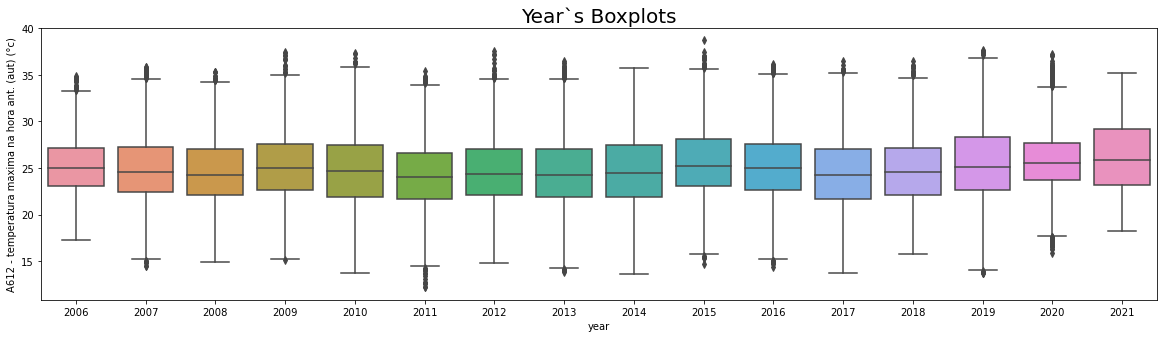

In [10]:
plt.figure(figsize=figsize2)
tittle = 'Year`s Boxplots'
_ = sns.boxplot(data=df,y = y2, x='year').set_title(tittle,fontsize=20)

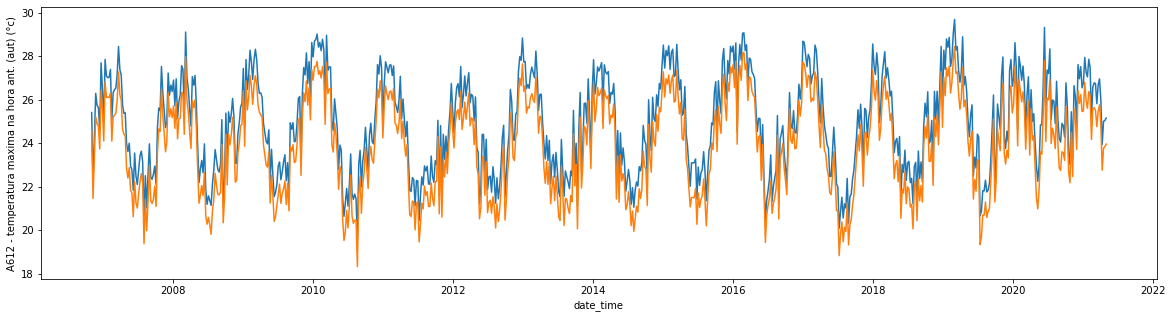

In [11]:
two_line_plot(df,y2,y3,freq='W')

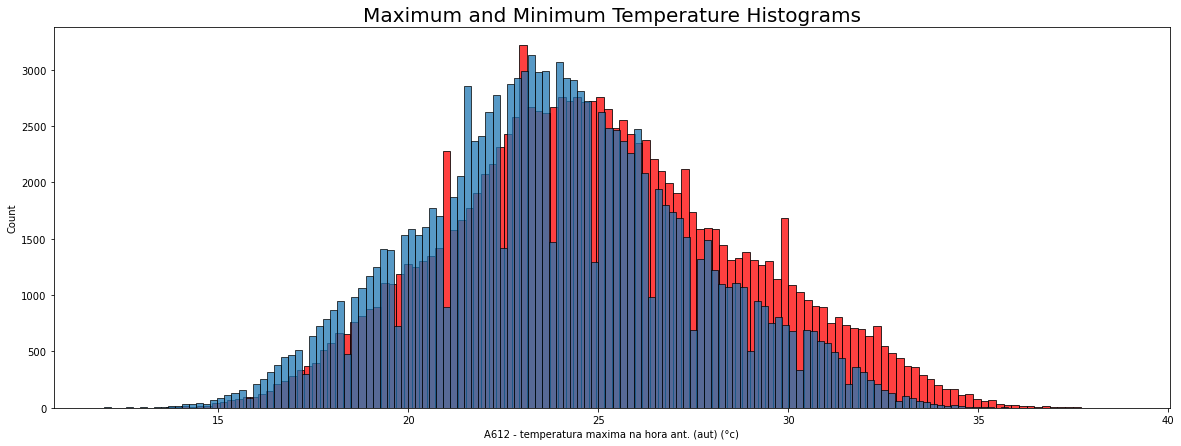

In [12]:
plt.figure(figsize=figsize)
tittle = 'Maximum and Minimum Temperature Histograms'
_ = sns.histplot(df[y2],color = 'red').set_title(tittle,fontsize=20)
_ = sns.histplot(df[y3])
## plot have these holes because we just have one number after the .

---
## Rain

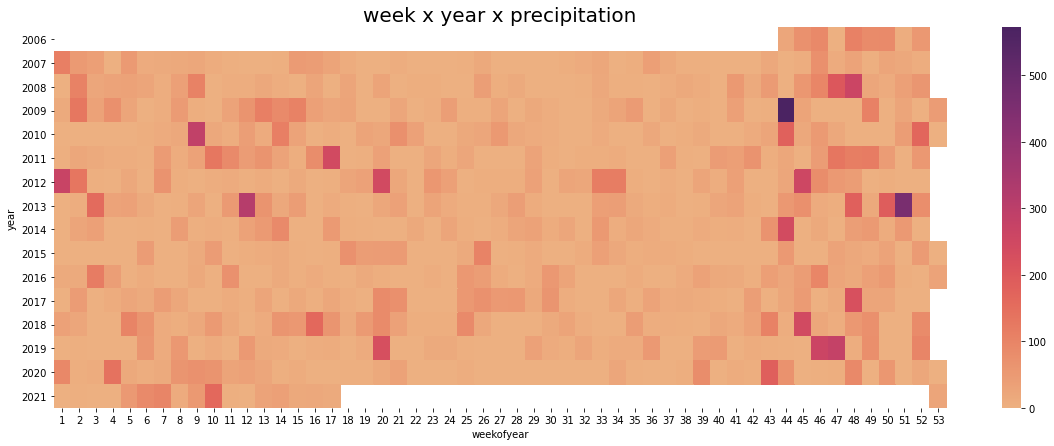

In [13]:
tittle = 'week x year x precipitation'
plt.figure(figsize = figsize)
temp = df[['weekofyear','year',y1]]
temp = temp.groupby(['year','weekofyear']).sum()
temp.reset_index(inplace=True)
temp = temp.pivot(index='year',columns='weekofyear',values=y1)
_ = sns.heatmap(temp,cmap="flare").set_title(tittle,fontsize=20)
## in summer we have more rain

Text(0.5, 1.0, 'week x year x precipitation')

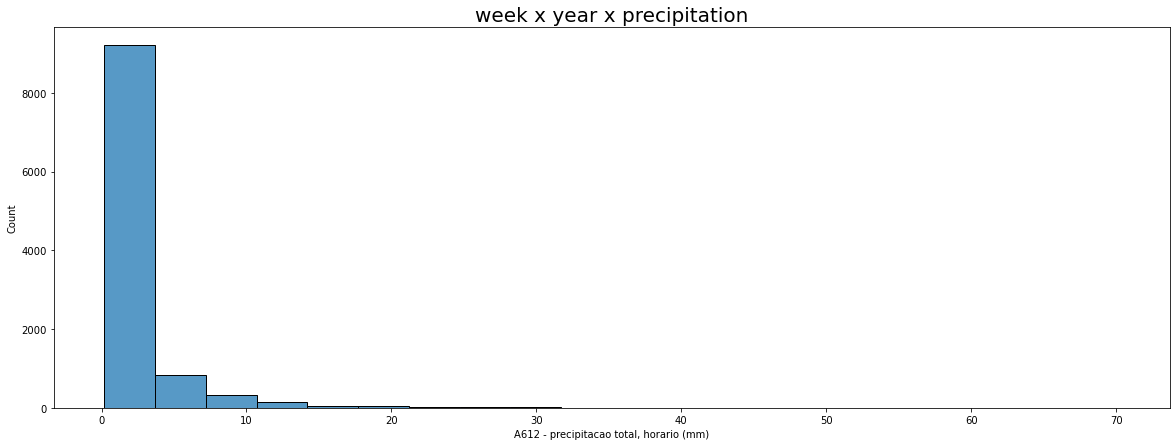

In [14]:
tittle = 'week x year x precipitation'
plt.figure(figsize = figsize)
sns.histplot(df[df[y1]>0][y1],bins=20).set_title(tittle,fontsize=20)
## dont rain most of the days thats why we see the zeros

---
## 3. X - Covariables
Covariables

#### Min max variables
1. pressao atmosferica min max
2. temperatura orvalho min e max
3. umidade min e max

#### Single variables
1. temperatura do ar - bulbo seco
2. temperatura do ponto de orvalho
3. vento direçao
4. vento rajada maxima
5. vento velocidade horaria

In [15]:
df.columns

Index(['date_time', 'A612 - precipitacao total, horario (mm)',
       'A612 - pressao atmosferica ao nivel da estacao, horaria (mb)',
       'A612 - pressao atmosferica max. na hora ant. (aut) (mb)',
       'A612 - pressao atmosferica min. na hora ant. (aut) (mb)',
       'A612 - temperatura do ar - bulbo seco, horaria (°c)',
       'A612 - temperatura do ponto de orvalho (°c)',
       'A612 - temperatura maxima na hora ant. (aut) (°c)',
       'A612 - temperatura minima na hora ant. (aut) (°c)',
       'A612 - temperatura orvalho max. na hora ant. (aut) (°c)',
       'A612 - temperatura orvalho min. na hora ant. (aut) (°c)',
       'A612 - umidade rel. max. na hora ant. (aut) (%)',
       'A612 - umidade rel. min. na hora ant. (aut) (%)',
       'A612 - umidade relativa do ar, horaria (%)',
       'A612 - vento direcao horaria (gr) (° (gr))',
       'A612 - vento rajada maxima (m/s)',
       'A612 - vento velocidade horaria (m/s)', 'hour', 'month', 'year',
       'day_of_year', 'weeko

<Figure size 1440x504 with 0 Axes>

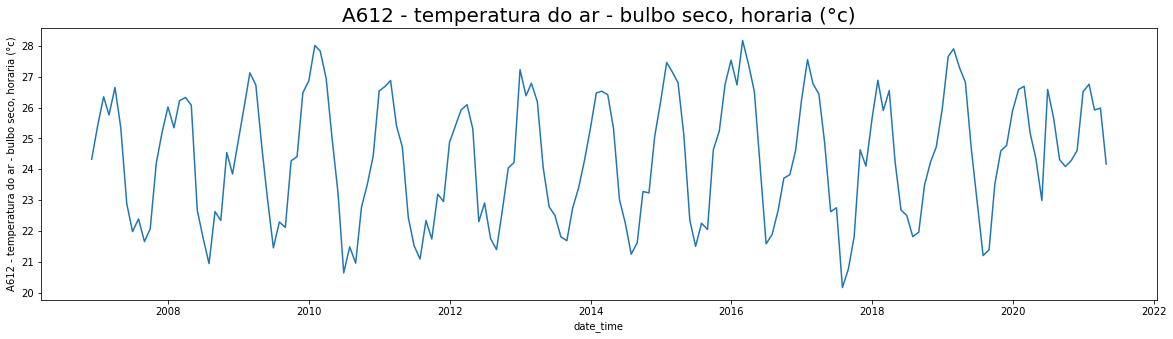

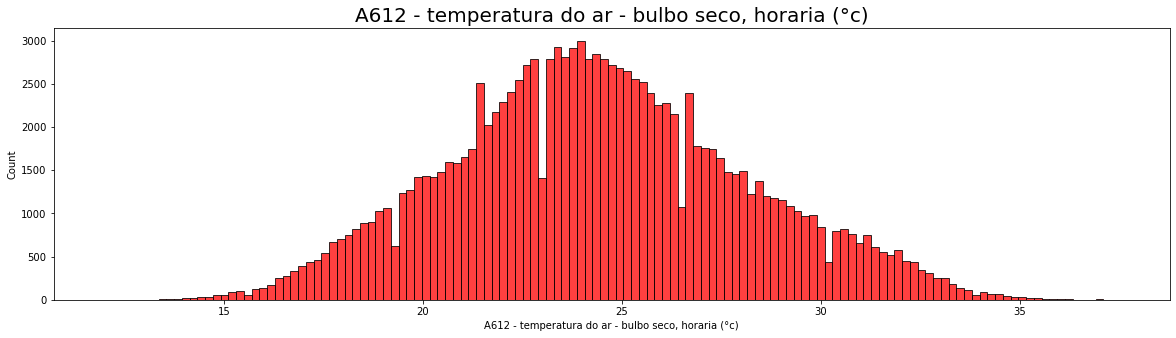

In [16]:
x1 = 'A612 - temperatura do ar - bulbo seco, horaria (°c)'
tittle = x1
plt.figure(figsize=figsize)
one_line_plot(df,x1 = x1, freq='M', tittle = tittle)
one_hist_plot(df,x1 = x1, freq='M', tittle = tittle)

<Figure size 1440x504 with 0 Axes>

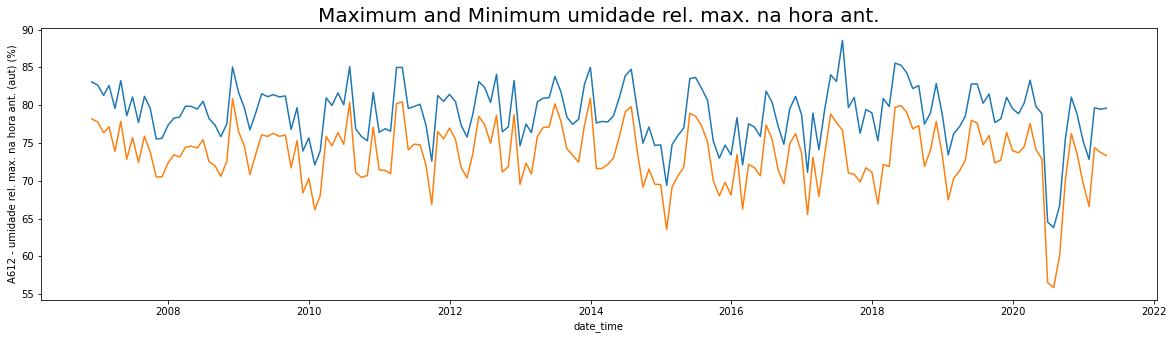

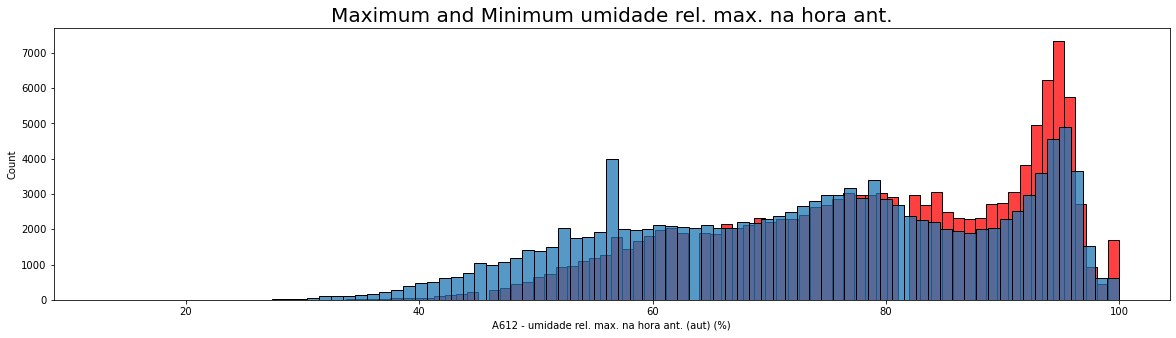

In [17]:
x1 = 'A612 - umidade rel. max. na hora ant. (aut) (%)'
x2 = 'A612 - umidade rel. min. na hora ant. (aut) (%)'
tittle = 'Maximum and Minimum umidade rel. max. na hora ant.'
plt.figure(figsize=figsize)
two_line_plot(df,x1 = x1,x2 =x2 ,freq='M', tittle = tittle)
two_hist_plot(df,x1 = x1,x2 =x2 ,freq='M', tittle = tittle)

<AxesSubplot:>

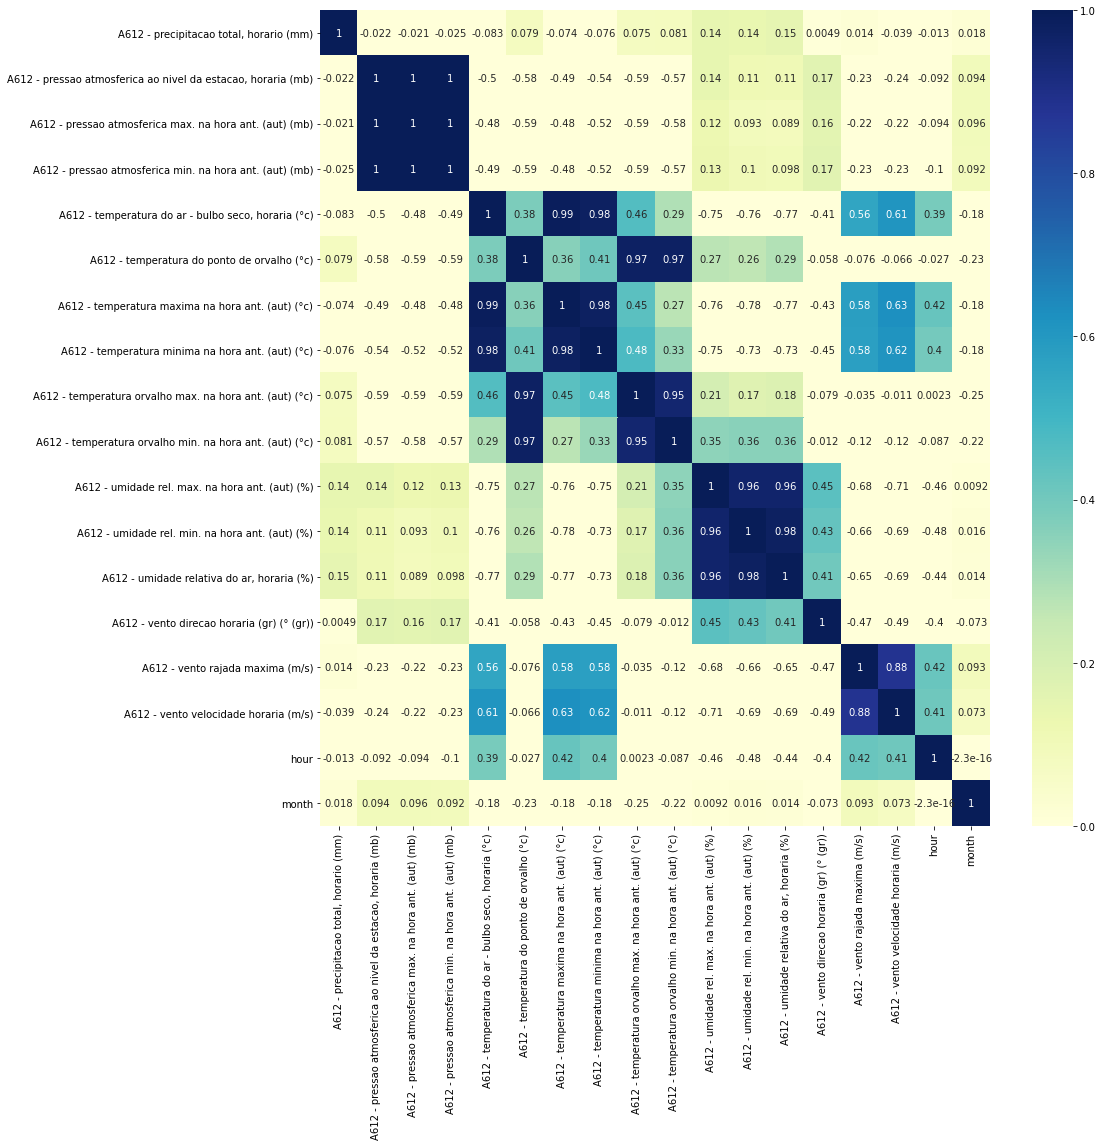

In [18]:
plt.figure(figsize = (15,15)) 
sns.heatmap(df.iloc[:,1:-6].corr(),cmap="YlGnBu",vmin=0,annot=True)
# can see that will be necessary select the variables because of multicolinearity, or a PCA or a "AR PCA"

<Figure size 1440x1440 with 0 Axes>

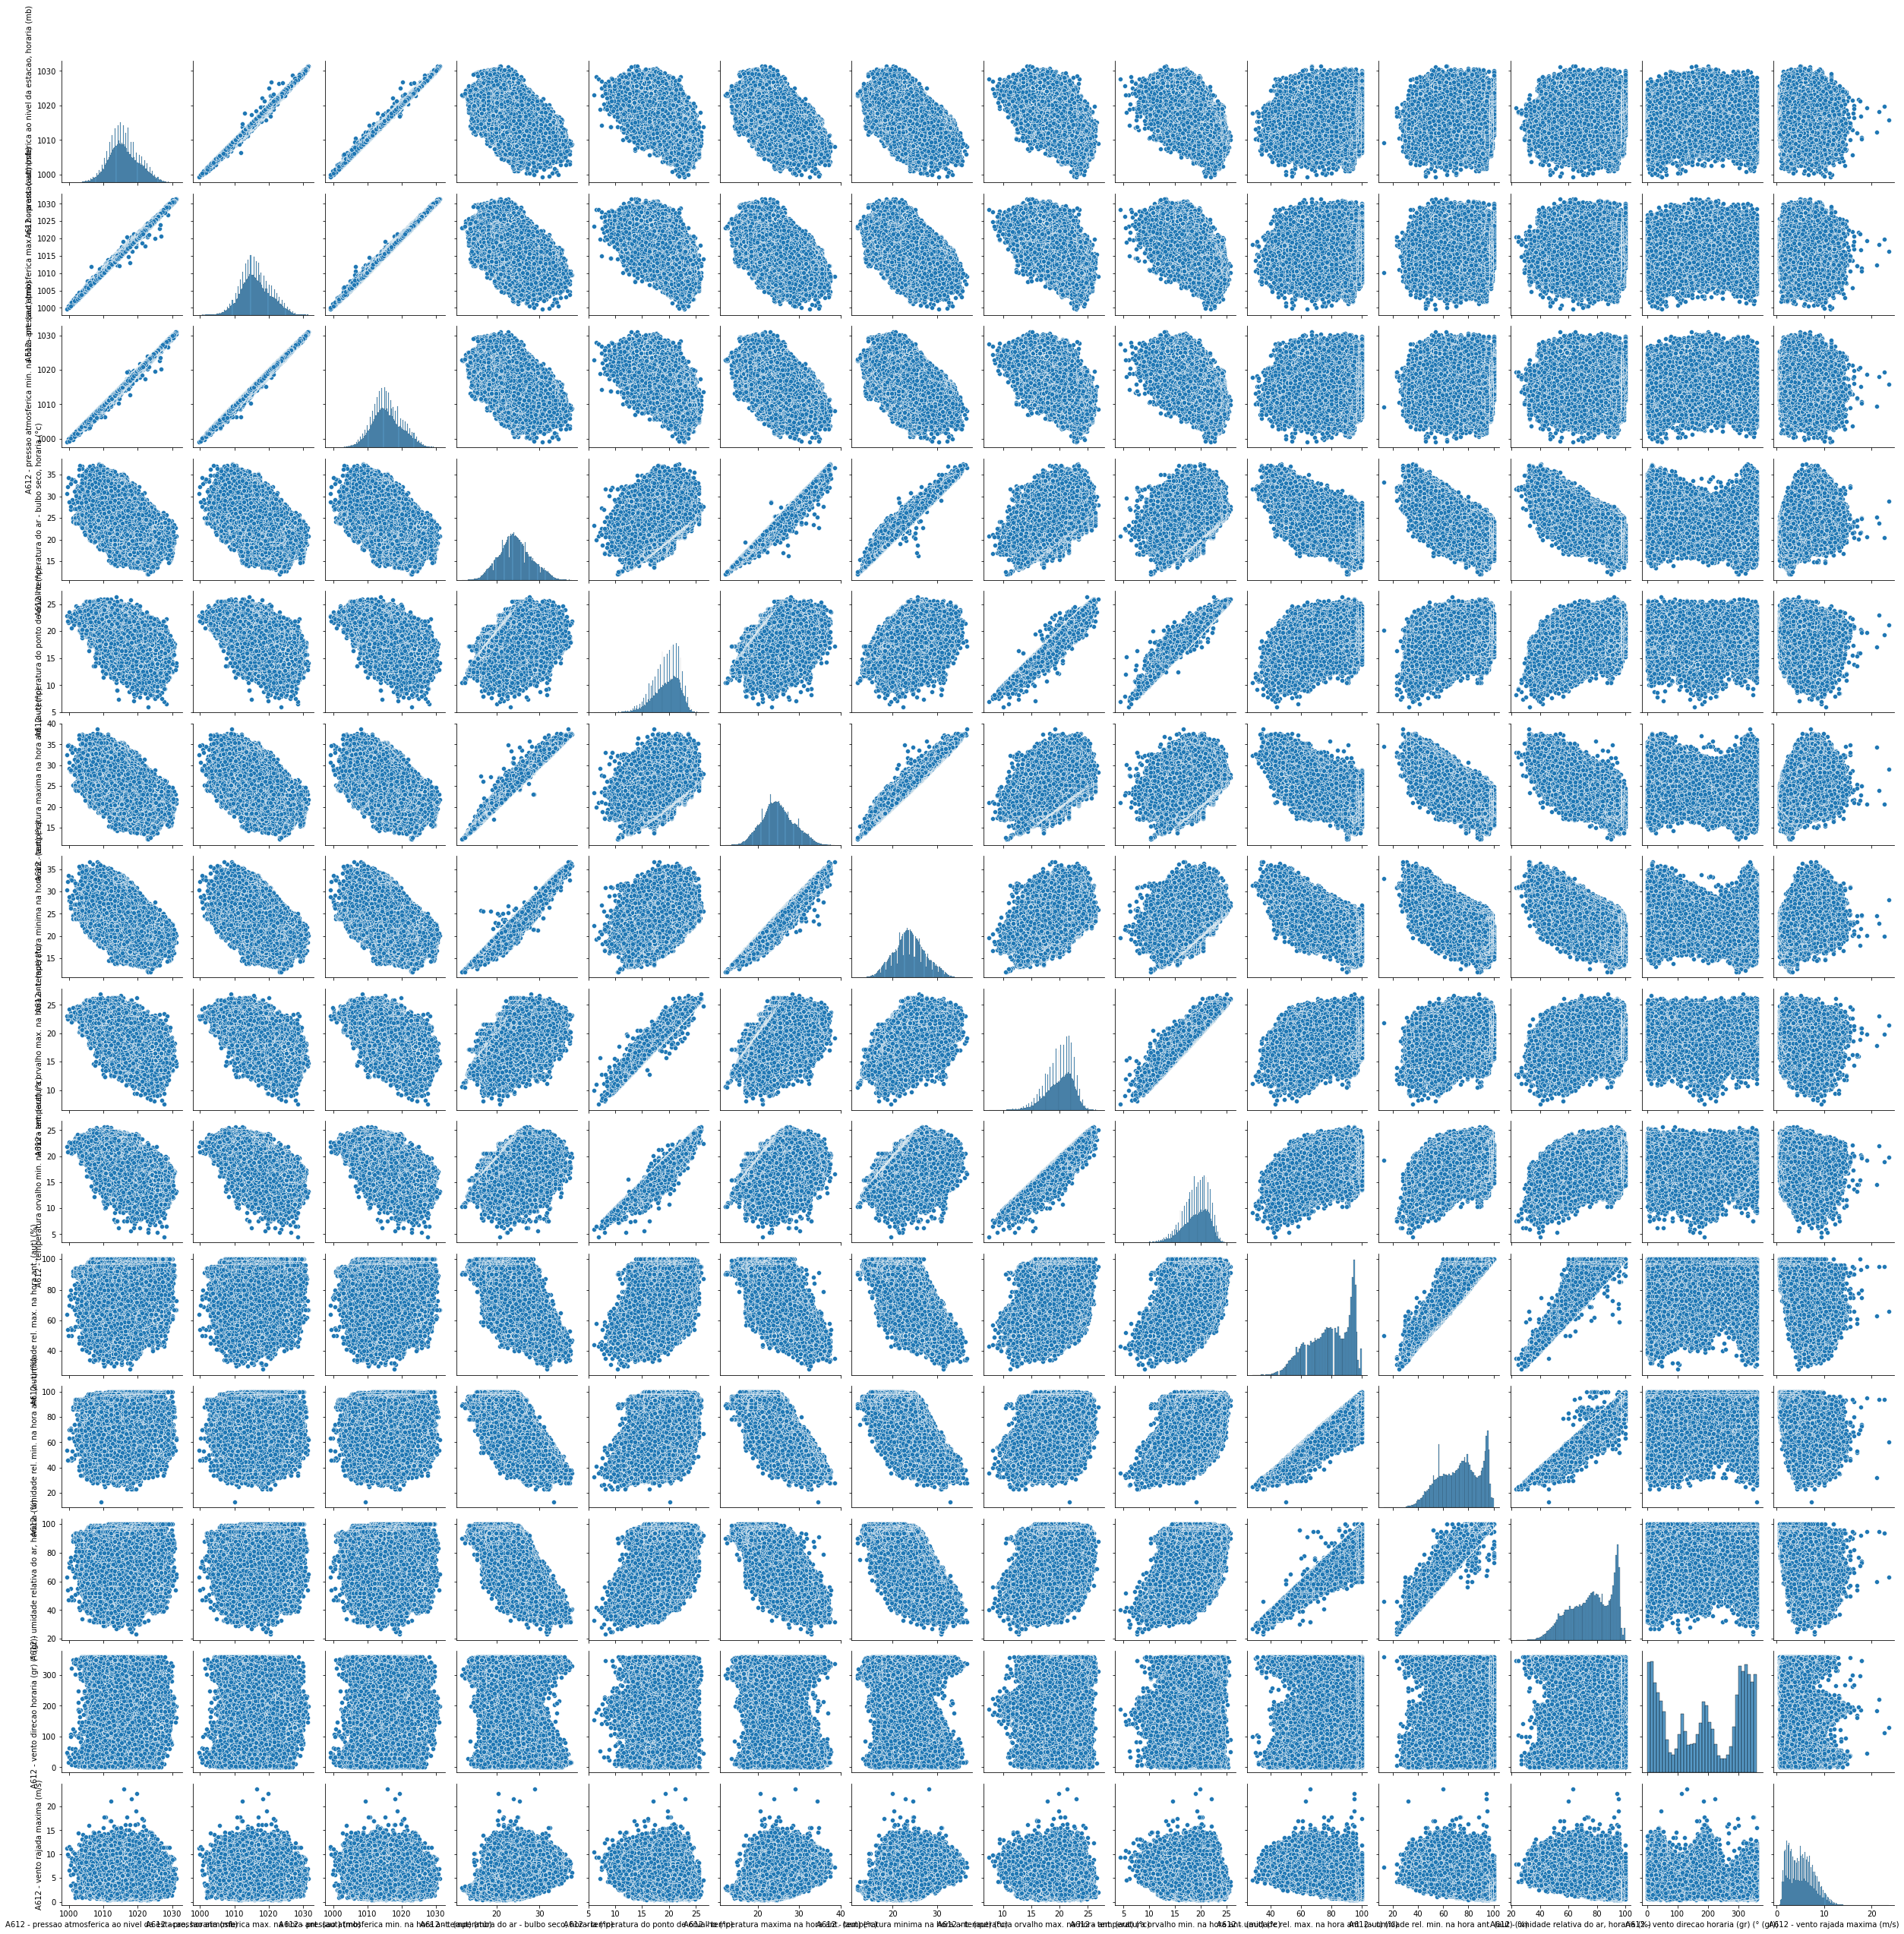

In [19]:
plt.figure(figsize = (20, 20)) 
_ = sns.pairplot(df.iloc[:,2:-9])
# we can see the multicolinearity again

---
## 4.  Errors from Linear Regression

In [20]:
from statsmodels.regression.linear_model import OLS
from jh_utils.data.pandas.preprocessing import make_dummies
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [21]:
df_model = df[df.date_time < '01-01-2020']

In [22]:
_y_ = df_model[['A612 - precipitacao total, horario (mm)','A612 - temperatura minima na hora ant. (aut) (°c)','A612 - temperatura minima na hora ant. (aut) (°c)']]
x = df_model.iloc[:,-7:]
x['hour'] = df_model.hour
x = x.drop(['day_of_year','weekofyear','year'],axis=1)

In [23]:
x = pd.concat([x,make_dummies(x['month'])],axis=1)
x.drop(['month', 'hour'],axis=1,inplace=True)
x['intercept'] = 1

In [24]:
def mean_abs_deviation(y):
    return ((y - y.mean()).apply(abs)).mean()

def median_abs_deviation(y):
    return ((y - y.median()).apply(abs)).median()

In [25]:
def ols_model(x,y):
    x_train, x_test = x[df_model.date_time<'01-01-2018'], x[df_model.date_time>='01-01-2018']
    y_train, y_test = y[df_model.date_time<'01-01-2018'], y[df_model.date_time>='01-01-2018']
    model = OLS(y_train,x_train)
    fit = model.fit()
    y_pred = fit.predict(x_test)
    
    print(f'mean abs deviation: {mean_abs_deviation(y_test)}')
    print(f'mean absolute error  : {mean_absolute_error(y_test,y_pred)}')
    print('---')
    print(f'median abs deviation: {median_abs_deviation(y_test)}')
    print(f'median absolute error: {median_absolute_error(y_test,y_pred)}')
    return y_pred, fit, model

In [27]:
# y_pred_0, fit_0, model_0 = ols_model(x,_y_.iloc[:,0])
y_pred_1, fit_1, model_1 = ols_model(x,_y_.iloc[:,1])
# print('---')
# y_pred_2, fit_2, model_2 = ols_model(x_dummy,_y_.iloc[:,1])

mean abs deviation: 2.907495302172599
mean absolute error  : 1.6822048040370292
---
median abs deviation: 2.400000000000002
median absolute error: 1.398029803702002


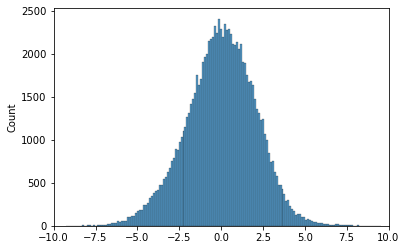

In [28]:
plt.xlim(-10,10)
_ = sns.histplot(fit_1.resid,)

In [32]:
_ = plot_acf(fit_1.resid)
_ = plot_pacf(fit_1.resid)

In [30]:
df_plot = pd.DataFrame(df_model.date_time[:len(fit_1.resid)])
df_plot['resid'] = fit_1.resid
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()

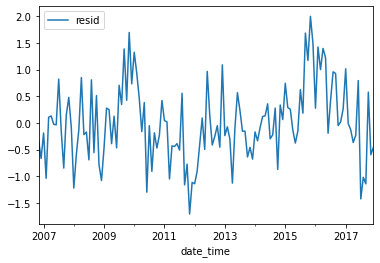

In [31]:
_ = df_plot.plot()

## Conclusions
#### EDA:
1. year sazonality
2. hour transformation
3. multicolinarity
4. 2020 unregular year
5. outliers (possibles errors) created by cleanning NAs(will be replaced in the future)

#### Ordinary Least Squares
1. Errors look like are normal (not tested)
2. Autoregressive information in the regression residuals

metric|value
---|---
mean abs deviation| 2.907495302172599
mean absolute error| 1.6822048040370292
median abs deviation| 2.400000000000002
median absolute error| 1.398029803702002

The OLS model have a decent fit with just non-stocastic covariables, but we still have information in the data that we will try to explained using autoregressive information and adding extra covariables.